# Fraud Detection in Electricity and Gas Consumption

The Tunisian Company of Electricity and Gas (STEG) is a public and a non-administrative company, it is responsible for delivering electricity and gas across Tunisia. The company suffered tremendous losses in the order of 200 million Tunisian Dinars due to fraudulent manipulations of meters by consumers.

Using the client’s billing history, the aim of the challenge is to detect and recognize clients involved in fraudulent activities.

The solution will enhance the company’s revenues and reduce the losses caused by such fraudulent activities.

# Team 5

## Data analysis and inspection

First thing we need to do is import the neccessary packages that we are going to be using.

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from collections import Counter

sns.set()

%matplotlib inline

Loading the datasets into our file as a pandas dataframe

In [2]:
client_data = pd.read_csv('Data/client_train.csv',low_memory = False)
invoice_data = pd.read_csv('Data/invoice_train.csv',low_memory = False)

Taking a peek at the client dataset to see what kind of monster we are dealing with.

In [3]:
client_data.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [4]:
client_data.shape

(135493, 6)

We also look at the invoice dataset

In [5]:
invoice_data.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [6]:
invoice_data.shape

(4476749, 16)

We see that we can immediatly calculate how many invoices there are per client and add that to our dataframe

In [7]:
client_data['invoice_amount'] = invoice_data.groupby('client_id').size().values
client_data.head()

,disrict,client_id,client_catg,region,creation_date,target,invoice_amount
0,60,train_Client_0,11,101,31/12/1994,0.0,35
1,69,train_Client_1,11,107,29/05/2002,0.0,37
2,62,train_Client_10,11,301,13/03/1986,0.0,18
3,69,train_Client_100,11,105,11/07/1996,0.0,20
4,62,train_Client_1000,11,303,14/10/2014,0.0,14


We also see that we can change the dates to datetime format incase we will be needing that information later

In [8]:
# Changing the client_data's column date to datetime
client_data['creation_date']= pd.to_datetime(client_data['creation_date'])
# Changing the invoice_data's column date to datetime
invoice_data['invoice_date']= pd.to_datetime(invoice_data['invoice_date'])

The date can be used to calculate how long a customer has had a contract with the company because it might be usefull in our model

In [9]:
today = pd.to_datetime("today")
# Add the contract length in years 
client_data['contract_time_length'] = today.year - client_data['creation_date'].dt.year
client_data.head()

,disrict,client_id,client_catg,region,creation_date,target,invoice_amount,contract_time_length
0,60,train_Client_0,11,101,1994-12-31,0.0,35,27
1,69,train_Client_1,11,107,2002-05-29,0.0,37,19
2,62,train_Client_10,11,301,1986-03-13,0.0,18,35
3,69,train_Client_100,11,105,1996-11-07,0.0,20,25
4,62,train_Client_1000,11,303,2014-10-14,0.0,14,7


The date of the last invoice can differ a lot from the current date and so the number of years since the start of a clients contract with the company and the date of their last invoice will be used as well.

In [10]:
client_data['contract_time_to_latest'] = invoice_data.groupby('client_id')['invoice_date'].max().dt.year.values- client_data['creation_date'].dt.year.values
    
client_data.head()

,disrict,client_id,client_catg,region,creation_date,target,invoice_amount,contract_time_length,contract_time_to_latest
0,60,train_Client_0,11,101,1994-12-31,0.0,35,27,25
1,69,train_Client_1,11,107,2002-05-29,0.0,37,19,17
2,62,train_Client_10,11,301,1986-03-13,0.0,18,35,33
3,69,train_Client_100,11,105,1996-11-07,0.0,20,25,16
4,62,train_Client_1000,11,303,2014-10-14,0.0,14,7,5


Detailed decriptions of the old and new index columns was not given for the dataset however is thought that the change in this index might be of value.

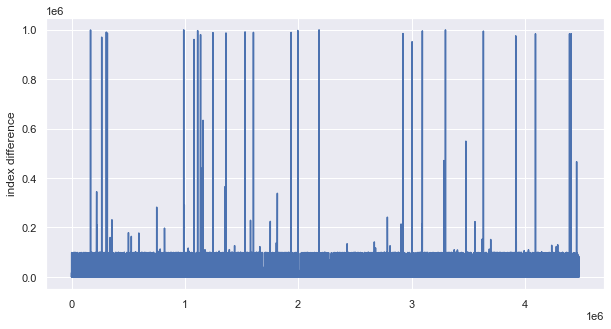

In [11]:
fig,ax = plt.subplots(figsize=(10,5))
invoice_data['index_dif'] = np.abs(invoice_data['new_index']-invoice_data['old_index'])

invoice_data.loc[:,'index_dif'].plot()
plt.ylabel('index difference');

There are large fluctuations in the difference of this value. Seeing how large difference values correspond to fraudulent clients is shown below:

In [12]:
print('0.75 quantile: ',invoice_data['index_dif'].quantile(0.75))
invoice_data.merge(client_data,on='client_id')[invoice_data['index_dif'] > invoice_data['index_dif'].quantile(0.75)]['target'].mean()*100

0.75 quantile:  657.0


8.796826157554776

8.8% of the values greater than the 0.75 quantile corresponds to fraudulent clients

The months number column was also not well defined. It is seen that this number is how many months have passed since the last invoice/inspection. However there are large outiers for this feature corresponding to 200+ years since the last invoice.

In [13]:
invoice_data['months_number'].describe()

count    4.476749e+06
mean     4.483095e+01
std      3.128335e+03
min      0.000000e+00
25%      4.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      6.366240e+05
Name: months_number, dtype: float64

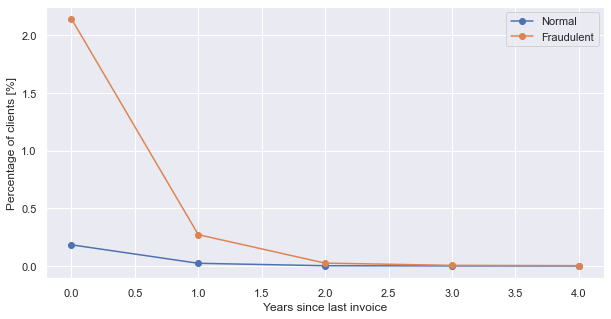

In [14]:
month_check = invoice_data[:].merge(client_data,on='client_id')
months =[]
for i in range(5):
    months.append(month_check[(month_check['months_number']>i*12)&(month_check['target']==1)].groupby('client_id').sum().shape[0])
    
fig,ax = plt.subplots(figsize=(10,5))
plt.plot((np.array(months)/month_check[month_check['target']==0].shape[0])*100,marker='o',label='Normal')
plt.plot((np.array(months)/month_check[month_check['target']==1].shape[0])*100,marker='o',label='Fraudulent')
plt.legend()
plt.ylabel('Percentage of clients [%]');
plt.xlabel('Years since last invoice');

As shown in the above graph we can safely remove the invoices that have large numbers in the 'months_number' column. Shown in the above graph, rows with larger than two year since the last invoice corresponds to removing 0.04% of the fraudulent clients.

In [15]:
invoice_data.drop(invoice_data[invoice_data.months_number > 24].index,inplace=True)

In [40]:
invoice_data['months_number'].describe()

count    4.473221e+06
mean     4.236397e+00
std      1.770281e+00
min      0.000000e+00
25%      4.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      2.400000e+01
Name: months_number, dtype: float64

In [16]:
print('Number of client: ',client_data.shape[0])
print('Number of clients in reduced invoice data set: ',invoice_data['client_id'].unique().shape[0])
print('Number of removed clients: ',client_data.shape[0]-invoice_data['client_id'].unique().shape[0])

Number of client:  135493
Number of clients in reduced invoice data set:  135356
Number of removed clients:  137


In [17]:
client_data.head()

,disrict,client_id,client_catg,region,creation_date,target,invoice_amount,contract_time_length,contract_time_to_latest
0,60,train_Client_0,11,101,1994-12-31,0.0,35,27,25
1,69,train_Client_1,11,107,2002-05-29,0.0,37,19,17
2,62,train_Client_10,11,301,1986-03-13,0.0,18,35,33
3,69,train_Client_100,11,105,1996-11-07,0.0,20,25,16
4,62,train_Client_1000,11,303,2014-10-14,0.0,14,7,5


We then want to one hot encode the data

In [24]:
#Drop columns not deemed neccesary
reduced_invoice_data = invoice_data.drop(columns=['counter_code','counter_number','old_index','new_index','invoice_date'])

reduced_client_data = client_data.drop(columns=['disrict','region','creation_date'])

In [25]:
#Hot encode the categorical variables for the invoice dataset
cat_cols_invoice = ['tarif_type','counter_statue','reading_remarque','counter_coefficient','counter_type']

invoice_cat = pd.get_dummies(reduced_invoice_data,columns=cat_cols_invoice)
invoice_cat.head()

,client_id,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,months_number,index_dif,tarif_type_8,tarif_type_9,tarif_type_10,...,counter_coefficient_9,counter_coefficient_10,counter_coefficient_11,counter_coefficient_20,counter_coefficient_30,counter_coefficient_33,counter_coefficient_40,counter_coefficient_50,counter_type_ELEC,counter_type_GAZ
0,train_Client_0,82,0,0,0,4,82,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,train_Client_0,1200,184,0,0,4,1384,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,train_Client_0,123,0,0,0,4,123,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,train_Client_0,102,0,0,0,4,102,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,train_Client_0,572,0,0,0,12,572,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [23]:
#Hot encode the categorical variables for the client dataset
cat_cols_client = ['client_catg']

client_cat = pd.get_dummies(reduced_client_data,columns=cat_cols_client)
client_cat.head()

,client_id,target,invoice_amount,contract_time_length,contract_time_to_latest,client_catg_11,client_catg_12,client_catg_51
0,train_Client_0,0.0,35,27,25,1,0,0
1,train_Client_1,0.0,37,19,17,1,0,0
2,train_Client_10,0.0,18,35,33,1,0,0
3,train_Client_100,0.0,20,25,16,1,0,0
4,train_Client_1000,0.0,14,7,5,1,0,0


<span style="color:red">Needs markdown</span>

In [26]:
df_mean = invoice_cat.groupby('client_id').agg('mean').iloc[:,6:]
df_mean.head()

,tarif_type_8,tarif_type_9,tarif_type_10,tarif_type_11,tarif_type_12,tarif_type_13,tarif_type_14,tarif_type_15,tarif_type_18,tarif_type_21,...,counter_coefficient_9,counter_coefficient_10,counter_coefficient_11,counter_coefficient_20,counter_coefficient_30,counter_coefficient_33,counter_coefficient_40,counter_coefficient_50,counter_type_ELEC,counter_type_GAZ
client_id,,,,,,,,,,,,,,,,,,,,,
train_Client_0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
train_Client_1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
train_Client_10,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
train_Client_100,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
train_Client_1000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


<span style="color:red">Needs markdown</span>

In [28]:
df_cons= invoice_cat.groupby('client_id').agg({'consommation_level_1': ['min', 'max','mean','std'],
                                     'consommation_level_2': ['min', 'max','mean','std'],
                                     'consommation_level_3': ['min', 'max','mean','std'],
                                     'consommation_level_4': ['min', 'max','mean','std'],
                                     'index_dif': ['min', 'max','mean','std'],
                                     'months_number': ['min', 'max','mean','std']})

df_cons.columns = ['consommation_level_1_min','consommation_level_1_max','consommation_level_1_mean','consommation_level_1_std','consommation_level_2_min','consommation_level_2_max','consommation_level_2_mean','consommation_level_2_std','consommation_level_3_min','consommation_level_3_max','consommation_level_3_mean','consommation_level_3_std','consommation_level_4_min','consommation_level_4_max','consommation_level_4_mean','consommation_level_4_std','index_dif_min','index_dif_max','index_dif_mean','index_dif_std','months_number_min','months_number_max','months_number_mean','months_number_std']
df_cons.head()

,consommation_level_1_min,consommation_level_1_max,consommation_level_1_mean,consommation_level_1_std,consommation_level_2_min,consommation_level_2_max,consommation_level_2_mean,consommation_level_2_std,consommation_level_3_min,consommation_level_3_max,...,consommation_level_4_mean,consommation_level_4_std,index_dif_min,index_dif_max,index_dif_mean,index_dif_std,months_number_min,months_number_max,months_number_mean,months_number_std
client_id,,,,,,,,,,,,,,,,,,,,,
train_Client_0,38,1200,352.400000,310.343472,0,186,10.571429,43.568935,0,0,...,0.000000,0.000000,38,1386,362.971429,341.553930,2,12,4.628571,2.101620
train_Client_1,190,1207,557.540541,197.935960,0,0,0.000000,0.000000,0,0,...,0.000000,0.000000,190,1207,557.540541,197.935960,2,8,4.324324,1.375461
train_Client_10,188,2400,798.611111,513.841374,0,682,37.888889,160.748942,0,0,...,0.000000,0.000000,188,3082,836.500000,646.808386,4,12,6.444444,3.399346
train_Client_100,0,15,1.200000,3.607011,0,0,0.000000,0.000000,0,0,...,0.000000,0.000000,0,15,1.200000,3.607011,4,6,4.200000,0.615587
train_Client_1000,124,800,663.714286,224.831365,0,400,104.857143,167.155320,0,800,...,36.714286,105.421081,124,2382,922.642857,633.485669,2,4,3.714286,0.726273


In [29]:
#merging the grouped invoice data set of means and describe()
derived_invoice = df_cons.merge(df_mean,on='client_id')

In [38]:
#merging grouped invoice dataset with the original client dataset
final_dataset = client_cat.merge(derived_invoice,on='client_id')
final_dataset.drop(columns=['client_id'],inplace=True)

In [39]:
final_dataset.fillna(0,inplace=True) #There are NaN where because standard deviation of one invoice gives error
final_dataset.head() 

,target,invoice_amount,contract_time_length,contract_time_to_latest,client_catg_11,client_catg_12,client_catg_51,consommation_level_1_min,consommation_level_1_max,consommation_level_1_mean,...,counter_coefficient_9,counter_coefficient_10,counter_coefficient_11,counter_coefficient_20,counter_coefficient_30,counter_coefficient_33,counter_coefficient_40,counter_coefficient_50,counter_type_ELEC,counter_type_GAZ
0,0.0,35,27,25,1,0,0,38,1200,352.400000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,37,19,17,1,0,0,190,1207,557.540541,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,18,35,33,1,0,0,188,2400,798.611111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,20,25,16,1,0,0,0,15,1.200000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,14,7,5,1,0,0,124,800,663.714286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


<span style="color:red">We need to plot the data that we got and make comments on it</span>
    
<span style="color:red">We also need to one hot encode the rest of the categorical values</span>

<span style="color:red">We also need to decide what to do with district and region and we need to drop cliend_id</span>

## Data preparation 


<span style="color:red">Data reshaped using centering, normalization or standardization.
More than one type of data preprocessing technique was considered.
Motivation for the choice of technique.</span>

## Model choice

<span style="color:red">More than one type of model or different configurations of one model. Motivation as to why these models.</span>

## Model training 

<span style="color:red">Models trained , commentary on results (loss criteria, overfitting , how well the model fairs). Comentary on choice of loss metrics selection of optimizers. Training visualized through graphs (confusion matrix, accuracy estimates vs epoch)</span>

## Model tuning

<span style="color:red">Hyper-parameters were tuned and evaluated on the validation set. Commentary on the dierent hyper-
parameters. Performance of dierent values of hyper-parameters visualized through graphs.Choice of tuning technique justified (grid search, etc).</span>

## Model assesment

<span style="color:red">Results portrayed through tabular data and/or graphs. (confusion matrix, ROC curve, etc). Commentary regarding performance of the model. (Different models compared). Commentary regarding the choice of performance metric. (Accuracy, cross entropy loss, etc). Discussion on how performance could be increased further.</span>

## Final Model performance

<span style="color:red">90% - 100%</span>